##SECTION A --  Tractor Credit Risk Analysis  (Q1)

In [185]:
# STEP 1: Install pandasql
!pip install -q pandasql

# STEP 2: Import libraries
import pandas as pd
from pandasql import sqldf

# STEP 3: Load the CSV
df = pd.read_csv('/content/tractor_credit_data.csv')

In [186]:
pysqldf = lambda q: sqldf(q, globals())

In [188]:
query = """
SELECT
    upazila,
    COUNT(CASE WHEN emi_paid_months < 0.5 * total_emi_months THEN 1 END) * 1.0 / COUNT(*) AS low_emi_ratio,
    COUNT(*) AS total_customers
FROM
    df
GROUP BY
    upazila
HAVING
    COUNT(CASE WHEN emi_paid_months < 0.5 * total_emi_months THEN 1 END) > 0
ORDER BY
    low_emi_ratio DESC
LIMIT 5;
"""


top_5_upazilas = pysqldf(query)

In [189]:
top_5_upazilas

,upazila,low_emi_ratio,total_customers
0,Muradnagar,0.625000,16
1,Sadar,0.571429,28
2,Rupsha,0.566667,30
3,Gafargaon,0.533333,30
4,Shajahanpur,0.500000,14


##SECTION A --  Tractor Credit Risk Analysis  (Q2)

In [177]:
import pandas as pd
import numpy as np
!pip install -q pandasql
from pandasql import sqldf
import nltk
import string
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Load the dataset
df = pd.read_csv("/content/tractor_credit_data.csv")

In [2]:
df

,customer_id,upazila,district,purchase_month,total_credit_amount,emi_paid_months,total_emi_months,payment_delay_days,dealer_id,income_doc_score,land_ownership_flag
0,CUST_1000,Banaripara,Barishal,2023-07,346867,12,12,0,DEALER_8,320,0
1,CUST_1001,Godagari,Rajshahi,2023-11,287498,7,12,0,DEALER_8,430,0
2,CUST_1002,Sadar,Bogura,2023-02,394027,5,12,0,DEALER_1,759,1
3,CUST_1003,Daudkandi,Cumilla,2023-12,356730,9,12,0,DEALER_16,489,0
4,CUST_1004,Rupsha,Khulna,2023-12,231551,8,12,0,DEALER_19,320,1
...,...,...,...,...,...,...,...,...,...,...,...
295,CUST_1295,Paba,Rajshahi,2024-05,207099,6,12,5,DEALER_19,880,1
296,CUST_1296,Rupsha,Khulna,2023-01,353686,4,12,0,DEALER_8,804,1
297,CUST_1297,Daudkandi,Cumilla,2023-01,469932,2,12,0,DEALER_17,447,1
298,CUST_1298,Sadar,Bogura,2024-02,248355,10,12,60,DEALER_19,690,1


In [3]:
# Step 1: Calculate EMI Paid Ratio
df["emi_paid_ratio"] = df["emi_paid_months"] / df["total_emi_months"]

In [4]:
df

,customer_id,upazila,district,purchase_month,total_credit_amount,emi_paid_months,total_emi_months,payment_delay_days,dealer_id,income_doc_score,land_ownership_flag,emi_paid_ratio
0,CUST_1000,Banaripara,Barishal,2023-07,346867,12,12,0,DEALER_8,320,0,1.000000
1,CUST_1001,Godagari,Rajshahi,2023-11,287498,7,12,0,DEALER_8,430,0,0.583333
2,CUST_1002,Sadar,Bogura,2023-02,394027,5,12,0,DEALER_1,759,1,0.416667
3,CUST_1003,Daudkandi,Cumilla,2023-12,356730,9,12,0,DEALER_16,489,0,0.750000
4,CUST_1004,Rupsha,Khulna,2023-12,231551,8,12,0,DEALER_19,320,1,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
295,CUST_1295,Paba,Rajshahi,2024-05,207099,6,12,5,DEALER_19,880,1,0.500000
296,CUST_1296,Rupsha,Khulna,2023-01,353686,4,12,0,DEALER_8,804,1,0.333333
297,CUST_1297,Daudkandi,Cumilla,2023-01,469932,2,12,0,DEALER_17,447,1,0.166667
298,CUST_1298,Sadar,Bogura,2024-02,248355,10,12,60,DEALER_19,690,1,0.833333


In [5]:
def calculate_risk_score(row):
    score = 0

    # EMI Paid Ratio
    if row["emi_paid_ratio"] < 0.5:
        score += 2
    elif row["emi_paid_ratio"] < 0.75:
        score += 1

    # Payment Delay Days
    if row["payment_delay_days"] > 30:
        score += 2
    elif row["payment_delay_days"] > 0:
        score += 1

    # Income Doc Score
    if row["income_doc_score"] < 400:
        score += 2
    elif row["income_doc_score"] < 600:
        score += 1

    return score

In [7]:
# Apply scoring
df["risk_score"] = df.apply(calculate_risk_score, axis=1)

In [8]:
df

,customer_id,upazila,district,purchase_month,total_credit_amount,emi_paid_months,total_emi_months,payment_delay_days,dealer_id,income_doc_score,land_ownership_flag,emi_paid_ratio,risk_score
0,CUST_1000,Banaripara,Barishal,2023-07,346867,12,12,0,DEALER_8,320,0,1.000000,2
1,CUST_1001,Godagari,Rajshahi,2023-11,287498,7,12,0,DEALER_8,430,0,0.583333,2
2,CUST_1002,Sadar,Bogura,2023-02,394027,5,12,0,DEALER_1,759,1,0.416667,2
3,CUST_1003,Daudkandi,Cumilla,2023-12,356730,9,12,0,DEALER_16,489,0,0.750000,1
4,CUST_1004,Rupsha,Khulna,2023-12,231551,8,12,0,DEALER_19,320,1,0.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,CUST_1295,Paba,Rajshahi,2024-05,207099,6,12,5,DEALER_19,880,1,0.500000,2
296,CUST_1296,Rupsha,Khulna,2023-01,353686,4,12,0,DEALER_8,804,1,0.333333,2
297,CUST_1297,Daudkandi,Cumilla,2023-01,469932,2,12,0,DEALER_17,447,1,0.166667,3
298,CUST_1298,Sadar,Bogura,2024-02,248355,10,12,60,DEALER_19,690,1,0.833333,2


In [9]:
# Step 3: Categorize risk segment
def risk_category(score):
    if score <= 1:
        return "Low"
    elif score <= 3:
        return "Medium"
    else:
        return "High"

df["risk_segment"] = df["risk_score"].apply(risk_category)

In [10]:
df

,customer_id,upazila,district,purchase_month,total_credit_amount,emi_paid_months,total_emi_months,payment_delay_days,dealer_id,income_doc_score,land_ownership_flag,emi_paid_ratio,risk_score,risk_segment
0,CUST_1000,Banaripara,Barishal,2023-07,346867,12,12,0,DEALER_8,320,0,1.000000,2,Medium
1,CUST_1001,Godagari,Rajshahi,2023-11,287498,7,12,0,DEALER_8,430,0,0.583333,2,Medium
2,CUST_1002,Sadar,Bogura,2023-02,394027,5,12,0,DEALER_1,759,1,0.416667,2,Medium
3,CUST_1003,Daudkandi,Cumilla,2023-12,356730,9,12,0,DEALER_16,489,0,0.750000,1,Low
4,CUST_1004,Rupsha,Khulna,2023-12,231551,8,12,0,DEALER_19,320,1,0.666667,3,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,CUST_1295,Paba,Rajshahi,2024-05,207099,6,12,5,DEALER_19,880,1,0.500000,2,Medium
296,CUST_1296,Rupsha,Khulna,2023-01,353686,4,12,0,DEALER_8,804,1,0.333333,2,Medium
297,CUST_1297,Daudkandi,Cumilla,2023-01,469932,2,12,0,DEALER_17,447,1,0.166667,3,Medium
298,CUST_1298,Sadar,Bogura,2024-02,248355,10,12,60,DEALER_19,690,1,0.833333,2,Medium


In [11]:
segment_counts = df["risk_segment"].value_counts().reset_index()
segment_counts.columns = ["risk_segment", "customer_count"]

In [12]:
segment_counts

,risk_segment,customer_count
0,Medium,179
1,Low,76
2,High,45


In [13]:
avg_delay_per_segment = df.groupby("risk_segment")["payment_delay_days"].mean().reset_index()
avg_delay_per_segment.columns = ["risk_segment", "avg_payment_delay_days"]

In [14]:
avg_delay_per_segment

,risk_segment,avg_payment_delay_days
0,High,14.777778
1,Low,2.368421
2,Medium,7.960894


In [15]:
risk_summary = pd.merge(segment_counts, avg_delay_per_segment, on="risk_segment")

In [16]:
risk_summary

,risk_segment,customer_count,avg_payment_delay_days
0,Medium,179,7.960894
1,Low,76,2.368421
2,High,45,14.777778


##SECTION B — Fraud Pattern in Dealership Transactions (Q3)

In [30]:
pysqldf = lambda q: sqldf(q, globals())

  Preparing metadata (setup.py) ... done


In [32]:
query = """
SELECT
    dealer_id,
    SUM(CASE WHEN customer_nid_duplicate_flag = 1 OR same_phone_multiple_buyers_flag = 1 THEN 1 ELSE 0 END) AS fraud_count,
    COUNT(*) AS total_transactions
FROM df
GROUP BY dealer_id
HAVING SUM(CASE WHEN customer_nid_duplicate_flag = 1 OR same_phone_multiple_buyers_flag = 1 THEN 1 ELSE 0 END) > 3
ORDER BY fraud_count DESC;
"""

result = pysqldf(query)

In [33]:
print(result)

    dealer_id  fraud_count  total_transactions
0   DEALER_13            9                  33
1   DEALER_16            8                  22
2   DEALER_15            7                  29
3   DEALER_12            7                  12
4   DEALER_11            7                  25
5    DEALER_4            5                  23
6    DEALER_3            5                  18
7    DEALER_2            5                  21
8   DEALER_19            5                  19
9   DEALER_18            5                  20
10  DEALER_14            5                  19
11   DEALER_9            4                  20
12   DEALER_6            4                  13
13   DEALER_5            4                  18


##SECTION B — Fraud Pattern in Dealership Transactions (Q4)

In [17]:
# Step 1: Load the CSV data
df = pd.read_csv('/content/dealer_transaction_data.csv')

In [18]:
df

,dealer_id,transaction_id,sale_date,unit_sold,discount_applied,credit_approved,customer_nid_duplicate_flag,referral_code_used,same_phone_multiple_buyers_flag
0,DEALER_15,TRANS_1000,2024-01-03,1,0,1,0,0,0
1,DEALER_17,TRANS_1001,2024-01-17,2,0,1,0,1,0
2,DEALER_4,TRANS_1002,2024-05-02,2,10000,1,0,1,0
3,DEALER_11,TRANS_1003,2024-06-05,3,0,1,0,0,0
4,DEALER_18,TRANS_1004,2024-02-18,1,10000,1,0,1,0
...,...,...,...,...,...,...,...,...,...
395,DEALER_2,TRANS_1395,2023-03-12,2,15000,1,0,0,1
396,DEALER_18,TRANS_1396,2023-12-29,1,10000,1,0,0,0
397,DEALER_19,TRANS_1397,2023-07-17,3,0,1,0,0,0
398,DEALER_19,TRANS_1398,2023-10-13,1,10000,1,0,0,0


In [19]:
# Calculate suspicious activity rate
df['is_suspicious'] = (df['customer_nid_duplicate_flag'] == 1) | (df['same_phone_multiple_buyers_flag'] == 1)

In [20]:
df

,dealer_id,transaction_id,sale_date,unit_sold,discount_applied,credit_approved,customer_nid_duplicate_flag,referral_code_used,same_phone_multiple_buyers_flag,is_suspicious
0,DEALER_15,TRANS_1000,2024-01-03,1,0,1,0,0,0,False
1,DEALER_17,TRANS_1001,2024-01-17,2,0,1,0,1,0,False
2,DEALER_4,TRANS_1002,2024-05-02,2,10000,1,0,1,0,False
3,DEALER_11,TRANS_1003,2024-06-05,3,0,1,0,0,0,False
4,DEALER_18,TRANS_1004,2024-02-18,1,10000,1,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...
395,DEALER_2,TRANS_1395,2023-03-12,2,15000,1,0,0,1,True
396,DEALER_18,TRANS_1396,2023-12-29,1,10000,1,0,0,0,False
397,DEALER_19,TRANS_1397,2023-07-17,3,0,1,0,0,0,False
398,DEALER_19,TRANS_1398,2023-10-13,1,10000,1,0,0,0,False


In [21]:
dealer_stats = df.groupby('dealer_id').agg(
    total_transactions=('transaction_id', 'count'),
    suspicious_transactions=('is_suspicious', 'sum')
).reset_index()

In [22]:
dealer_stats

,dealer_id,total_transactions,suspicious_transactions
0,DEALER_1,14,3
1,DEALER_10,24,3
2,DEALER_11,25,7
3,DEALER_12,12,7
4,DEALER_13,33,9
5,DEALER_14,19,5
6,DEALER_15,29,7
7,DEALER_16,22,8
8,DEALER_17,30,3
9,DEALER_18,20,5


In [23]:
dealer_stats['suspicious_rate'] = (dealer_stats['suspicious_transactions'] / dealer_stats['total_transactions']) * 100

# Select top 10 dealers by suspicious activity rate
top_10_dealers = dealer_stats.sort_values(by='suspicious_rate', ascending=False).head(10)

In [24]:
top_10_dealers

,dealer_id,total_transactions,suspicious_transactions,suspicious_rate
3,DEALER_12,12,7,58.333333
7,DEALER_16,22,8,36.363636
15,DEALER_6,13,4,30.769231
2,DEALER_11,25,7,28.000000
12,DEALER_3,18,5,27.777778
4,DEALER_13,33,9,27.272727
5,DEALER_14,19,5,26.315789
10,DEALER_19,19,5,26.315789
9,DEALER_18,20,5,25.000000
6,DEALER_15,29,7,24.137931


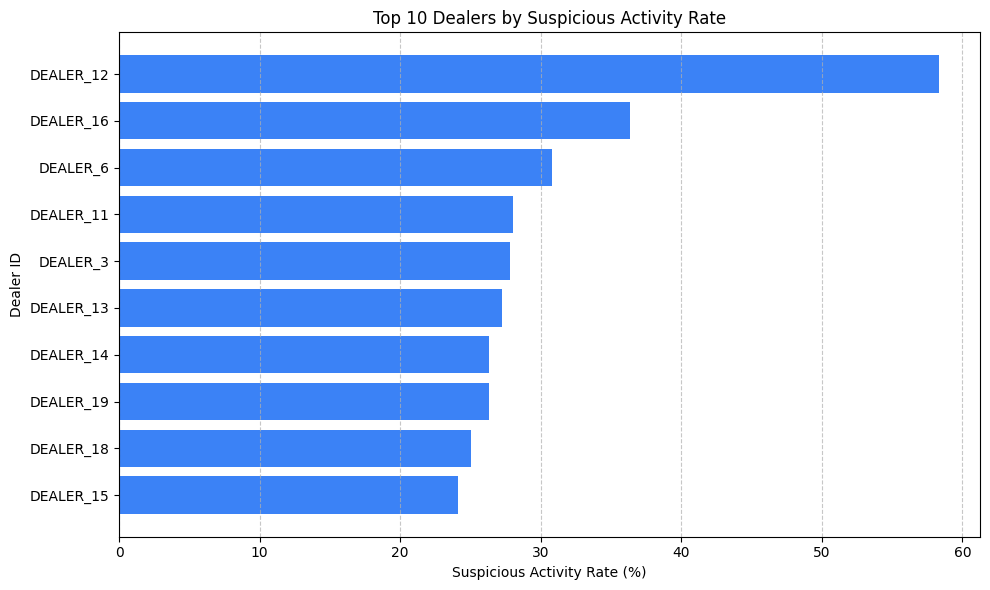

In [25]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_dealers['dealer_id'], top_10_dealers['suspicious_rate'], color='#3b82f6')
plt.xlabel('Suspicious Activity Rate (%)')
plt.ylabel('Dealer ID')
plt.title('Top 10 Dealers by Suspicious Activity Rate')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

In [26]:
plt.savefig('top_10_dealers_suspicious_activity_rate.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [29]:
# Analyze and print observations
print(
    f"Summary:\n"
    f"- Suspicious activity rate reflects the % of transactions flagged by NID or phone duplication.\n"
    f"- Top dealer ({top_10_dealers.iloc[0]['dealer_id']}) has a high suspicious rate of {top_10_dealers.iloc[0]['suspicious_rate']:.2f}%.\n"
    f"- {'Multiple dealers show rates >50%, indicating potential fraud clusters.' if top_10_dealers['suspicious_rate'].max() > 50 else 'No dealer exceeds 50% suspicious rate.'}\n"
    f"- {'Several dealers fall in the 40–50% range, suggesting similar verification issues.' if (top_10_dealers['suspicious_rate'].between(40, 50).sum() > 3) else 'No strong clustering between 40–50% range.'}\n"
    f"- High-risk dealers should be investigated further."
)


Summary:
- Suspicious activity rate reflects the % of transactions flagged by NID or phone duplication.
- Top dealer (DEALER_12) has a high suspicious rate of 58.33%.
- Multiple dealers show rates >50%, indicating potential fraud clusters.
- No strong clustering between 40–50% range.
- High-risk dealers should be investigated further.


##SECTION C – Location-Based Segmentation & Marketing (Q5)


In [34]:
# Load the dataset
data = pd.read_csv('/content/yamaha_customer_data_with_geo.csv')

In [36]:
data

,customer_id,age,upazila,district,monthly_income,product_type,visit_frequency,purchase_intent_score,competitor_interest_flag,latitude,longitude
0,YAMAHA_1000,20,Bakerganj,Barishal,93463,Scooter,9,0.26,1,22.70,90.33
1,YAMAHA_1001,18,Rupsha,Khulna,72892,Scooter,1,0.96,0,22.79,89.59
2,YAMAHA_1002,33,Banaripara,Barishal,86219,Sports,6,0.21,0,22.80,90.10
3,YAMAHA_1003,18,Phultala,Khulna,61737,Sports,1,0.86,1,22.86,89.53
4,YAMAHA_1004,24,Sadar,Bogura,79691,Scooter,4,0.80,0,24.85,89.37
...,...,...,...,...,...,...,...,...,...,...,...
345,YAMAHA_1345,23,Trishal,Mymensingh,23586,Scooter,4,0.78,0,24.60,90.40
346,YAMAHA_1346,24,Shajahanpur,Bogura,33390,Commuter,4,0.53,0,24.75,89.39
347,YAMAHA_1347,37,Trishal,Mymensingh,19833,Scooter,5,0.44,0,24.60,90.40
348,YAMAHA_1348,18,Trishal,Mymensingh,47282,Sports,4,0.84,0,24.60,90.40


In [35]:
# numeric columns
numeric_cols = ['monthly_income', 'purchase_intent_score', 'visit_frequency', 'latitude', 'longitude']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [37]:
data[numeric_cols]

,monthly_income,purchase_intent_score,visit_frequency,latitude,longitude
0,93463,0.26,9,22.70,90.33
1,72892,0.96,1,22.79,89.59
2,86219,0.21,6,22.80,90.10
3,61737,0.86,1,22.86,89.53
4,79691,0.80,4,24.85,89.37
...,...,...,...,...,...
345,23586,0.78,4,24.60,90.40
346,33390,0.53,4,24.75,89.39
347,19833,0.44,5,24.60,90.40
348,47282,0.84,4,24.60,90.40


In [39]:
data = data.dropna(subset=numeric_cols)

In [40]:
data

,customer_id,age,upazila,district,monthly_income,product_type,visit_frequency,purchase_intent_score,competitor_interest_flag,latitude,longitude
0,YAMAHA_1000,20,Bakerganj,Barishal,93463,Scooter,9,0.26,1,22.70,90.33
1,YAMAHA_1001,18,Rupsha,Khulna,72892,Scooter,1,0.96,0,22.79,89.59
2,YAMAHA_1002,33,Banaripara,Barishal,86219,Sports,6,0.21,0,22.80,90.10
3,YAMAHA_1003,18,Phultala,Khulna,61737,Sports,1,0.86,1,22.86,89.53
4,YAMAHA_1004,24,Sadar,Bogura,79691,Scooter,4,0.80,0,24.85,89.37
...,...,...,...,...,...,...,...,...,...,...,...
345,YAMAHA_1345,23,Trishal,Mymensingh,23586,Scooter,4,0.78,0,24.60,90.40
346,YAMAHA_1346,24,Shajahanpur,Bogura,33390,Commuter,4,0.53,0,24.75,89.39
347,YAMAHA_1347,37,Trishal,Mymensingh,19833,Scooter,5,0.44,0,24.60,90.40
348,YAMAHA_1348,18,Trishal,Mymensingh,47282,Sports,4,0.84,0,24.60,90.40


In [41]:
#Customer Segmentation
features = ['monthly_income', 'purchase_intent_score', 'visit_frequency']
X = data[features]

In [43]:
X

,monthly_income,purchase_intent_score,visit_frequency
0,93463,0.26,9
1,72892,0.96,1
2,86219,0.21,6
3,61737,0.86,1
4,79691,0.80,4
...,...,...,...
345,23586,0.78,4
346,33390,0.53,4
347,19833,0.44,5
348,47282,0.84,4


In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
X_scaled

array([[ 1.50656645, -1.43422044,  1.52679889],
       [ 0.69948767,  1.51190187, -1.50944891],
       [ 1.2223567 , -1.64465774,  0.38820597],
       ...,
       [-1.38221925, -0.67664613,  0.00867499],
       [-0.3052903 ,  1.00685233, -0.37085598],
       [ 1.66083381,  0.50180279, -1.50944891]])

In [46]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

In [47]:
data['cluster']

,cluster
0,1
1,2
2,1
3,2
4,2
...,...
345,0
346,0
347,0
348,2


In [48]:
cluster_stats = data.groupby('cluster').agg({
    'monthly_income': 'mean',
    'purchase_intent_score': 'mean',
    'visit_frequency': 'mean'
}).reset_index()

In [49]:
cluster_stats

,cluster,monthly_income,purchase_intent_score,visit_frequency
0,0,28634.195489,0.579098,4.759398
1,1,74532.855856,0.392703,5.360360
2,2,67836.433962,0.845849,4.849057


In [50]:
def assign_cluster_name(row):
    if row['monthly_income'] > 75000 and row['purchase_intent_score'] > 0.7:
        return 'Premium Enthusiasts'
    elif row['visit_frequency'] > 6:
        return 'Frequent Browsers'
    else:
        return 'Budget Commuters'

In [51]:
cluster_stats['cluster_name'] = cluster_stats.apply(assign_cluster_name, axis=1)
cluster_name_map = cluster_stats.set_index('cluster')['cluster_name'].to_dict()
data['cluster_name'] = data['cluster'].map(cluster_name_map)

In [53]:
data['cluster_name']

,cluster_name
0,Budget Commuters
1,Budget Commuters
2,Budget Commuters
3,Budget Commuters
4,Budget Commuters
...,...
345,Budget Commuters
346,Budget Commuters
347,Budget Commuters
348,Budget Commuters


In [54]:
fig1 = px.scatter(
    data,
    x='monthly_income',
    y='purchase_intent_score',
    color='cluster_name',
    title='Customer Segments: Income vs Purchase Intent',
    labels={
        'monthly_income': 'Monthly Income (BDT)',
        'purchase_intent_score': 'Purchase Intent Score',
        'cluster_name': 'Customer Segment'
    },
    color_discrete_map={
        'Premium Enthusiasts': '#ff7300',
        'Frequent Browsers': '#00C49F',
        'Budget Commuters': '#8884d8'
    }
)
# fig1.update_layout(showlegend=True)

In [181]:
fig1

In [182]:
# Plot 2: Customer density heatmap
fig2 = go.Figure(go.Scattergeo(
    lon=data['longitude'],
    lat=data['latitude'],
    mode='markers',
    marker=dict(
        size=8,
        opacity=0.3,
        color='#ff7300'
    ),
    text=data['upazila']
))
fig2.update_layout(
    title='Customer Density by Location',
    geo=dict(
        scope='world',
        projection_type='mercator',
        center=dict(lat=23.7, lon=90.0),
        lataxis_range=[22, 25],
        lonaxis_range=[88, 91],
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)'
    )
)

In [58]:
# High-Potential Upazilas

filtered_data = data[data['product_type'].isin(['Sports', 'Scooter'])]

# Group by upazila and calculate metrics
upazila_stats = filtered_data.groupby('upazila').agg({
    'monthly_income': 'mean',
    'purchase_intent_score': 'mean',
    'customer_id': 'count',
    'product_type': lambda x: list(set(x))
}).reset_index()

In [59]:
upazila_stats

,upazila,monthly_income,purchase_intent_score,customer_id,product_type
0,Bakerganj,49087.214286,0.611429,14,"[Sports, Scooter]"
1,Banaripara,53502.041667,0.533333,24,"[Sports, Scooter]"
2,Daudkandi,46978.500000,0.534444,18,"[Sports, Scooter]"
3,Gafargaon,53931.277778,0.547778,18,"[Sports, Scooter]"
4,Godagari,65565.000000,0.668333,18,"[Sports, Scooter]"
5,Muradnagar,56262.470588,0.625294,17,"[Sports, Scooter]"
6,Paba,53071.066667,0.646667,15,"[Sports, Scooter]"
7,Phultala,56723.000000,0.641600,25,"[Sports, Scooter]"
8,Rupsha,57144.857143,0.678571,14,"[Sports, Scooter]"
9,Sadar,43437.888889,0.576667,9,"[Sports, Scooter]"


In [70]:
sports_data = data[data['product_type'] == 'Sports']
upazila_sports_counts = sports_data.groupby('upazila').agg({
    'customer_id': 'count',
    'monthly_income': 'mean',
    'purchase_intent_score': 'mean'
}).reset_index()
upazila_sports_counts = upazila_sports_counts.sort_values(by='purchase_intent_score', ascending=False)

In [73]:
upazila_sports_counts

,upazila,customer_id,monthly_income,purchase_intent_score
0,Bakerganj,6,34007.666667,0.725000
7,Phultala,8,61225.750000,0.722500
8,Rupsha,8,59258.250000,0.670000
10,Shajahanpur,6,49501.833333,0.668333
11,Trishal,9,62548.888889,0.645556
6,Paba,8,49570.375000,0.601250
2,Daudkandi,9,45708.888889,0.598889
1,Banaripara,14,53115.928571,0.549286
4,Godagari,4,60219.000000,0.547500
5,Muradnagar,10,62999.000000,0.524000


In [74]:
for _, row in upazila_sports_counts.head(3).iterrows():
    print(f"- {row['upazila']}: {row['customer_id']} customers, Avg Income: {row['monthly_income']:.0f} BDT, "
          f"Avg Intent: {row['purchase_intent_score']:.2f}")

- Bakerganj: 6 customers, Avg Income: 34008 BDT, Avg Intent: 0.72
- Phultala: 8 customers, Avg Income: 61226 BDT, Avg Intent: 0.72
- Rupsha: 8 customers, Avg Income: 59258 BDT, Avg Intent: 0.67


##SECTION C – Location-Based Segmentation & Marketing (Q6)

In [60]:
upazila_stats.columns = ['upazila', 'avg_income', 'avg_intent', 'customer_count', 'product_types']

# Filter upazilas based on criteria
high_potential = upazila_stats[
    (upazila_stats['avg_income'] > 50000) &
    (upazila_stats['avg_intent'] > 0.6)
]

In [61]:
upazila_stats.columns

Index(['upazila', 'avg_income', 'avg_intent', 'customer_count',
       'product_types'],
      dtype='object')

In [62]:
top_upazilas = high_potential.sort_values(by='avg_intent', ascending=False).head(3)

In [63]:
top_upazilas

,upazila,avg_income,avg_intent,customer_count,product_types
8,Rupsha,57144.857143,0.678571,14,"[Sports, Scooter]"
4,Godagari,65565.000000,0.668333,18,"[Sports, Scooter]"
11,Trishal,55315.615385,0.655385,13,"[Sports, Scooter]"


In [64]:
# Format the output
top_upazilas['avg_income'] = top_upazilas['avg_income'].round(0).astype(int)
top_upazilas['avg_intent'] = top_upazilas['avg_intent'].round(2)
top_upazilas['product_types'] = top_upazilas['product_types'].apply(lambda x: ', '.join(x))

In [65]:
top_upazilas[['upazila', 'customer_count', 'avg_income', 'product_types']].to_string(index=False)

' upazila  customer_count  avg_income   product_types\n  Rupsha              14       57145 Sports, Scooter\nGodagari              18       65565 Sports, Scooter\n Trishal              13       55316 Sports, Scooter'

In [66]:
print("\nTop 3 High-Potential Upazilas:")
print(top_upazilas[['upazila', 'customer_count', 'avg_income', 'product_types']].to_string(index=False))


Top 3 High-Potential Upazilas:
 upazila  customer_count  avg_income   product_types
  Rupsha              14       57145 Sports, Scooter
Godagari              18       65565 Sports, Scooter
 Trishal              13       55316 Sports, Scooter


In [68]:
top_upazilas.to_csv('top_upazilas.csv', index=False)

In [69]:
for upazila in top_upazilas['upazila']:
    print(f"- {upazila}: High income and intent, with interest in {top_upazilas[top_upazilas['upazila'] == upazila]['product_types'].iloc[0]}")

- Rupsha: High income and intent, with interest in Sports, Scooter
- Godagari: High income and intent, with interest in Sports, Scooter
- Trishal: High income and intent, with interest in Sports, Scooter


##SECTION D — Financial Monitoring & Insight Dashboard (Q7)

##1

In [76]:
df = pd.read_csv('/content/financial_tracking_data.csv')

In [77]:
df

,month,dealer_id,total_units_sold,credit_units,cash_units,total_revenue,total_discount,credit_approved_flag,avg_emi_delay_days,region,district,operational_cost,net_profit,marketing_spend,roi
0,2023-01,DEALER_1,13,8,5,3609515,115615,1,0,South,Mymensingh,295006,3198894,14300.0,223.70
1,2023-01,DEALER_2,39,2,37,11942190,252254,1,15,North,Barishal,498215,11191721,46800.0,239.14
2,2023-01,DEALER_3,20,4,16,7806300,198796,1,5,North,Mymensingh,359070,7248434,24000.0,302.02
3,2023-01,DEALER_4,34,22,12,12296712,77039,0,10,South,Dhaka,442347,11777326,37400.0,314.90
4,2023-01,DEALER_5,41,4,37,8644563,127755,1,10,South,Khulna,518648,7998160,45100.0,177.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-06,DEALER_16,6,6,0,1584888,288001,1,5,East,Barishal,128924,1167963,5400.0,216.29
356,2024-06,DEALER_17,34,14,20,10536362,80843,0,5,Central,Chattogram,449377,10006142,44200.0,226.38
357,2024-06,DEALER_18,8,0,8,2658016,153617,0,10,East,Khulna,233343,2271056,7200.0,315.42
358,2024-06,DEALER_19,23,10,13,4752559,58740,1,10,West,Mymensingh,399820,4293999,23000.0,186.70


In [78]:
#handle missing/invalid values
numeric_cols = ['total_units_sold', 'credit_units', 'cash_units', 'total_revenue',
                'total_discount', 'avg_emi_delay_days', 'operational_cost',
                'net_profit', 'marketing_spend', 'roi']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [80]:
df

,month,dealer_id,total_units_sold,credit_units,cash_units,total_revenue,total_discount,credit_approved_flag,avg_emi_delay_days,region,district,operational_cost,net_profit,marketing_spend,roi
0,2023-01,DEALER_1,13,8,5,3609515,115615,1,0,South,Mymensingh,295006,3198894,14300.0,223.70
1,2023-01,DEALER_2,39,2,37,11942190,252254,1,15,North,Barishal,498215,11191721,46800.0,239.14
2,2023-01,DEALER_3,20,4,16,7806300,198796,1,5,North,Mymensingh,359070,7248434,24000.0,302.02
3,2023-01,DEALER_4,34,22,12,12296712,77039,0,10,South,Dhaka,442347,11777326,37400.0,314.90
4,2023-01,DEALER_5,41,4,37,8644563,127755,1,10,South,Khulna,518648,7998160,45100.0,177.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-06,DEALER_16,6,6,0,1584888,288001,1,5,East,Barishal,128924,1167963,5400.0,216.29
356,2024-06,DEALER_17,34,14,20,10536362,80843,0,5,Central,Chattogram,449377,10006142,44200.0,226.38
357,2024-06,DEALER_18,8,0,8,2658016,153617,0,10,East,Khulna,233343,2271056,7200.0,315.42
358,2024-06,DEALER_19,23,10,13,4752559,58740,1,10,West,Mymensingh,399820,4293999,23000.0,186.70


In [81]:
# format large numbers for display
def format_number(num):
    if num >= 1e6:
        return f"{num / 1e6:.1f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"
    return f"{num:.0f}"

In [180]:
fig = px.bar(
        regional_roi,
        x='region',
        y='roi',
        title='Average ROI by Region',
        labels={'roi': 'Average ROI', 'region': 'Region'},
        color='roi',
        color_continuous_scale=['#ef4444' if x < 200 else '#3b82f6' for x in regional_roi['roi']]
    )
fig.update_layout(
        xaxis_title="Region",
        yaxis_title="Average ROI",
        xaxis_tickangle=-45,
        showlegend=False,
        height=500,
        template='plotly_white'
    )
fig.show()

In [83]:
regional_roi

,region,roi
1,East,297.051389
4,West,278.527500
3,South,250.715093
2,North,239.869722
0,Central,216.671111


### Task 1: Regional ROI Analysis

In [85]:
fig = px.bar(
        regional_roi,
        x='region',
        y='roi',
        title='Average ROI by Region',
        labels={'roi': 'Average ROI', 'region': 'Region'},
        color='roi',
        color_continuous_scale=['#ef4444' if x < 200 else '#3b82f6' for x in regional_roi['roi']]
    )
fig.update_layout(
        xaxis_title="Region",
        yaxis_title="Average ROI",
        xaxis_tickangle=-45,
        showlegend=False,
        height=500,
        template='plotly_white'
    )

In [88]:
print(f"Regional ROI Insights: {regional_roi.iloc[0]['region']} leads with highest ROI ({regional_roi.iloc[0]['roi']:.2f}); recommend auditing low-ROI regions and reallocating marketing or training dealers.")

Regional ROI Insights: East leads with highest ROI (297.05); recommend auditing low-ROI regions and reallocating marketing or training dealers.


## Task 2: Profit vs Marketing Spend Analysis

In [89]:
scatter_data = df[['marketing_spend', 'net_profit']].copy()


In [90]:
scatter_data

,marketing_spend,net_profit
0,14300.0,3198894
1,46800.0,11191721
2,24000.0,7248434
3,37400.0,11777326
4,45100.0,7998160
...,...,...
355,5400.0,1167963
356,44200.0,10006142
357,7200.0,2271056
358,23000.0,4293999


In [91]:
# Calculate linear regression
slope, intercept = np.polyfit(scatter_data['marketing_spend'], scatter_data['net_profit'], 1)
trendline_x = np.array([scatter_data['marketing_spend'].min(), scatter_data['marketing_spend'].max()])
trendline_y = slope * trendline_x + intercept

In [93]:
trendline_x

array([ 5000., 63700.])

In [95]:
# Calculate correlation coefficient
correlation = scatter_data.corr().iloc[0, 1]
correlation

np.float64(0.8881630191258814)

In [99]:


# Create scatter plot with trendline
fig = px.scatter(
        scatter_data,
        x='marketing_spend',
        y='net_profit',
        title='Net Profit vs Marketing Spend',
        labels={'marketing_spend': 'Marketing Spend', 'net_profit': 'Net Profit'},
        color_discrete_sequence=['#3b82f6']
    )
fig.add_trace(
        go.Scatter(
            x=trendline_x,
            y=trendline_y,
            mode='lines',
            name='Trendline',
            line=dict(color='#ef4444')
        )
    )
fig.update_layout(
        xaxis_title="Marketing Spend",
        yaxis_title="Net Profit",
        showlegend=True,
        height=500,
        template='plotly_white',
        xaxis_tickformat='~s',
        yaxis_tickformat='~s'
    )

    # Save or display the plot
fig.show()

In [97]:
print(f"Profit vs Marketing Spend: Corr={correlation:.2f}, showing a moderate positive link. Some dealers earn >15M profit with <20K spend, highlighting strong efficiency.")


Profit vs Marketing Spend: Corr=0.89, showing a moderate positive link. Some dealers earn >15M profit with <20K spend, highlighting strong efficiency.


##SECTION E — Analyze and Visualize Customer Feedback (Q8)

#Processing

In [154]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv('/content/yamaha_mock_customer_feedback.csv')
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,customer_id,comment_text,platform,product_category,rating,sentiment,comment_date
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,"Mileage is very low, not as advertised.",Survey,Yamaha RayZR,1,negative,2024-02-18
1,bc8960a9-23b8-41e9-b924-56de3eb13b90,Facing frequent engine starting issues.,YouTube,Yamaha FZS,2,negative,2023-10-07
2,8b9d2434-e465-4150-bd9c-66b3ad3c2d6d,Excellent performance and smooth ride.,Dealer Visit,Yamaha MT-15,5,positive,2023-09-25
3,07a0ca6e-0822-48f3-ac03-1199972a8469,"Mileage is very low, not as advertised.",Facebook,Yamaha R15,1,negative,2023-09-30
4,9a1de644-815e-46d1-bb8f-aa1837f8a88b,Not satisfied with customer support.,Dealer Visit,Yamaha FZS,2,negative,2023-08-09
...,...,...,...,...,...,...,...
49995,757b4721-86f4-4b45-9690-08c6e196dcb3,Decent build quality but a bit expensive.,YouTube,Yamaha RayZR,3,neutral,2024-12-01
49996,cce682c6-65ad-48e5-99e5-2b428ded8e7a,It's okay for daily commuting.,YouTube,Yamaha R15,3,neutral,2023-09-17
49997,ae5a8302-acb2-4ca3-884e-0fc9c8e5b9c3,Great experience at the service center.,Facebook,Yamaha R15,4,positive,2025-01-24
49998,57d0e1ff-e342-40e3-ad71-cbd4159e0c8b,The seat is uncomfortable for long rides.,Instagram,Yamaha RayZR,1,negative,2025-03-02


In [155]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

df['cleaned_feedback'] = df['comment_text'].apply(preprocess_text)

In [156]:
df

,customer_id,comment_text,platform,product_category,rating,sentiment,comment_date,cleaned_feedback
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,"Mileage is very low, not as advertised.",Survey,Yamaha RayZR,1,negative,2024-02-18,mileage low advertised
1,bc8960a9-23b8-41e9-b924-56de3eb13b90,Facing frequent engine starting issues.,YouTube,Yamaha FZS,2,negative,2023-10-07,facing frequent engine starting issue
2,8b9d2434-e465-4150-bd9c-66b3ad3c2d6d,Excellent performance and smooth ride.,Dealer Visit,Yamaha MT-15,5,positive,2023-09-25,excellent performance smooth ride
3,07a0ca6e-0822-48f3-ac03-1199972a8469,"Mileage is very low, not as advertised.",Facebook,Yamaha R15,1,negative,2023-09-30,mileage low advertised
4,9a1de644-815e-46d1-bb8f-aa1837f8a88b,Not satisfied with customer support.,Dealer Visit,Yamaha FZS,2,negative,2023-08-09,satisfied customer support
...,...,...,...,...,...,...,...,...
49995,757b4721-86f4-4b45-9690-08c6e196dcb3,Decent build quality but a bit expensive.,YouTube,Yamaha RayZR,3,neutral,2024-12-01,decent build quality bit expensive
49996,cce682c6-65ad-48e5-99e5-2b428ded8e7a,It's okay for daily commuting.,YouTube,Yamaha R15,3,neutral,2023-09-17,okay daily commuting
49997,ae5a8302-acb2-4ca3-884e-0fc9c8e5b9c3,Great experience at the service center.,Facebook,Yamaha R15,4,positive,2025-01-24,great experience service center
49998,57d0e1ff-e342-40e3-ad71-cbd4159e0c8b,The seat is uncomfortable for long rides.,Instagram,Yamaha RayZR,1,negative,2025-03-02,seat uncomfortable long ride


##Sentiment Analysis

In [157]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['cleaned_feedback'].apply(get_sentiment)

In [158]:
df

,customer_id,comment_text,platform,product_category,rating,sentiment,comment_date,cleaned_feedback
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,"Mileage is very low, not as advertised.",Survey,Yamaha RayZR,1,Negative,2024-02-18,mileage low advertised
1,bc8960a9-23b8-41e9-b924-56de3eb13b90,Facing frequent engine starting issues.,YouTube,Yamaha FZS,2,Neutral,2023-10-07,facing frequent engine starting issue
2,8b9d2434-e465-4150-bd9c-66b3ad3c2d6d,Excellent performance and smooth ride.,Dealer Visit,Yamaha MT-15,5,Positive,2023-09-25,excellent performance smooth ride
3,07a0ca6e-0822-48f3-ac03-1199972a8469,"Mileage is very low, not as advertised.",Facebook,Yamaha R15,1,Negative,2023-09-30,mileage low advertised
4,9a1de644-815e-46d1-bb8f-aa1837f8a88b,Not satisfied with customer support.,Dealer Visit,Yamaha FZS,2,Positive,2023-08-09,satisfied customer support
...,...,...,...,...,...,...,...,...
49995,757b4721-86f4-4b45-9690-08c6e196dcb3,Decent build quality but a bit expensive.,YouTube,Yamaha RayZR,3,Neutral,2024-12-01,decent build quality bit expensive
49996,cce682c6-65ad-48e5-99e5-2b428ded8e7a,It's okay for daily commuting.,YouTube,Yamaha R15,3,Positive,2023-09-17,okay daily commuting
49997,ae5a8302-acb2-4ca3-884e-0fc9c8e5b9c3,Great experience at the service center.,Facebook,Yamaha R15,4,Positive,2025-01-24,great experience service center
49998,57d0e1ff-e342-40e3-ad71-cbd4159e0c8b,The seat is uncomfortable for long rides.,Instagram,Yamaha RayZR,1,Negative,2025-03-02,seat uncomfortable long ride


/tmp/ipython-input-3109598506.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




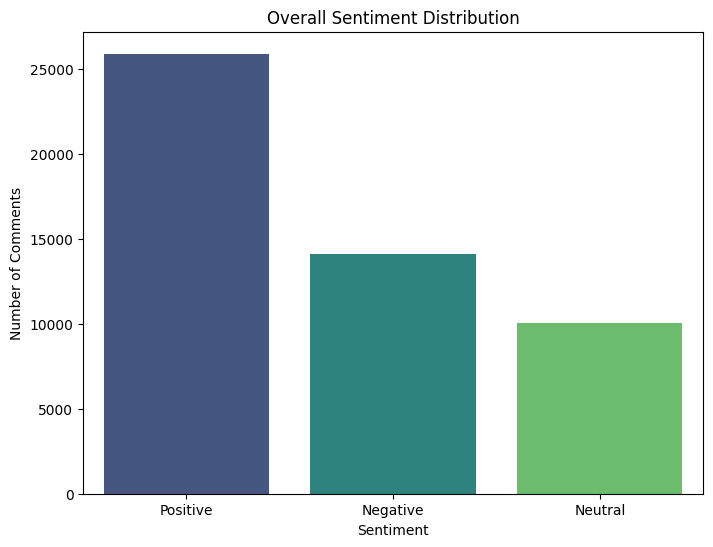

In [160]:
# Plot overall sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.savefig('overall_sentiment_distribution.png')
plt.show()

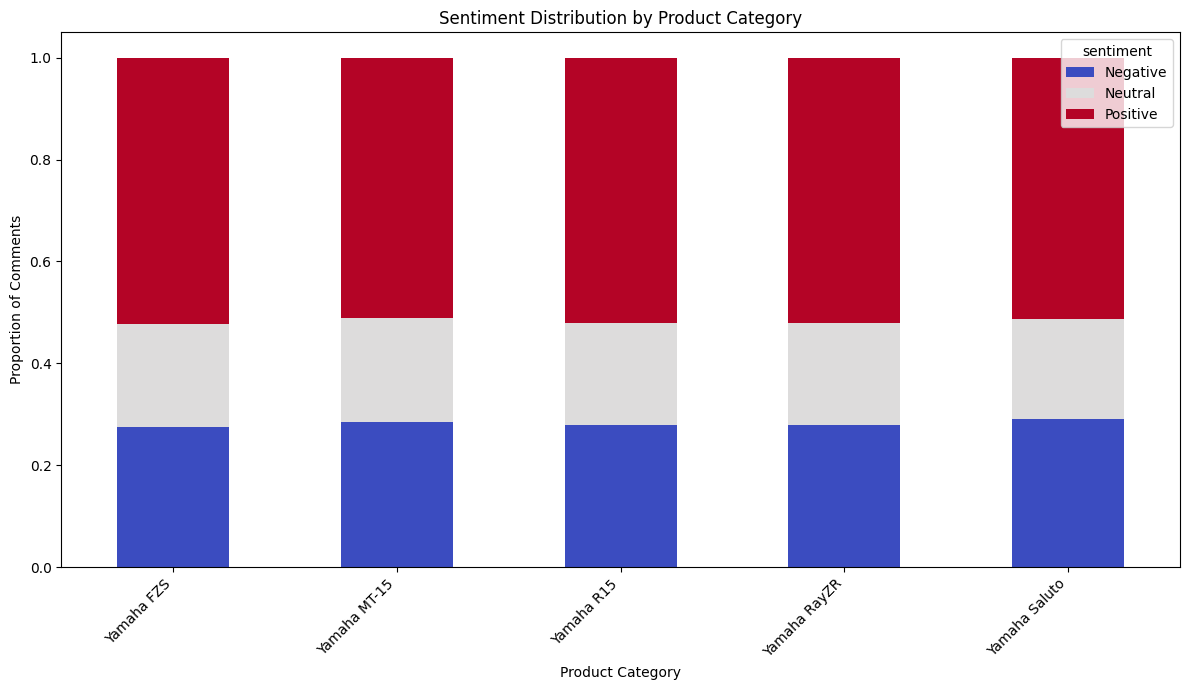

In [161]:
# Show sentiment by product category
sentiment_by_category = df.groupby('product_category')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
sentiment_by_category.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='coolwarm')
plt.title('Sentiment Distribution by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Proportion of Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sentiment_by_product_category.png')
plt.show()

##Topic Modeling

In [165]:
vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_feedback'])

num_topics = 4  # Aim for 3-5 themes
kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
kmeans.fit(X)
df['topic'] = kmeans.labels_


In [166]:
df

,customer_id,comment_text,platform,product_category,rating,sentiment,comment_date,cleaned_feedback,topic
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,"Mileage is very low, not as advertised.",Survey,Yamaha RayZR,1,Negative,2024-02-18,mileage low advertised,1
1,bc8960a9-23b8-41e9-b924-56de3eb13b90,Facing frequent engine starting issues.,YouTube,Yamaha FZS,2,Neutral,2023-10-07,facing frequent engine starting issue,3
2,8b9d2434-e465-4150-bd9c-66b3ad3c2d6d,Excellent performance and smooth ride.,Dealer Visit,Yamaha MT-15,5,Positive,2023-09-25,excellent performance smooth ride,2
3,07a0ca6e-0822-48f3-ac03-1199972a8469,"Mileage is very low, not as advertised.",Facebook,Yamaha R15,1,Negative,2023-09-30,mileage low advertised,1
4,9a1de644-815e-46d1-bb8f-aa1837f8a88b,Not satisfied with customer support.,Dealer Visit,Yamaha FZS,2,Positive,2023-08-09,satisfied customer support,0
...,...,...,...,...,...,...,...,...,...
49995,757b4721-86f4-4b45-9690-08c6e196dcb3,Decent build quality but a bit expensive.,YouTube,Yamaha RayZR,3,Neutral,2024-12-01,decent build quality bit expensive,1
49996,cce682c6-65ad-48e5-99e5-2b428ded8e7a,It's okay for daily commuting.,YouTube,Yamaha R15,3,Positive,2023-09-17,okay daily commuting,1
49997,ae5a8302-acb2-4ca3-884e-0fc9c8e5b9c3,Great experience at the service center.,Facebook,Yamaha R15,4,Positive,2025-01-24,great experience service center,1
49998,57d0e1ff-e342-40e3-ad71-cbd4159e0c8b,The seat is uncomfortable for long rides.,Instagram,Yamaha RayZR,1,Negative,2025-03-02,seat uncomfortable long ride,2


In [168]:
print("\nTop 5 keywords per topic:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_topics):
    print(f"Topic {i}:")
    for ind in order_centroids[i, :5]:
        print(f' - {terms[ind]}')


Top 5 keywords per topic:
Topic 0:
 - satisfied
 - support
 - customer
 - fuel
 - efficiency
Topic 1:
 - service
 - poor
 - aftersales
 - advertised
 - low
Topic 2:
 - ride
 - smooth
 - excellent
 - uncomfortable
 - long
Topic 3:
 - engine
 - performance
 - outstanding
 - starting
 - frequent


##Word Cloud

In [169]:
positive_feedback = ' '.join(df[df['sentiment'] == 'Positive']['cleaned_feedback'])
negative_feedback = ' '.join(df[df['sentiment'] == 'Negative']['cleaned_feedback'])

In [170]:
positive_feedback

'excellent performance smooth ride satisfied customer support satisfied fuel efficiency satisfied fuel efficiency okay daily commuting okay daily commuting okay daily commuting excellent performance smooth ride great experience service center great experience service center satisfied customer support satisfied fuel efficiency great experience service center engine performance outstanding engine performance outstanding stylish design comfortable seating great experience service center satisfied customer support excellent performance smooth ride satisfied fuel efficiency excellent performance smooth ride excellent performance smooth ride excellent performance smooth ride satisfied customer support engine performance outstanding engine performance outstanding satisfied fuel efficiency great experience service center excellent performance smooth ride satisfied fuel efficiency satisfied customer support satisfied fuel efficiency engine performance outstanding stylish design comfortable seat

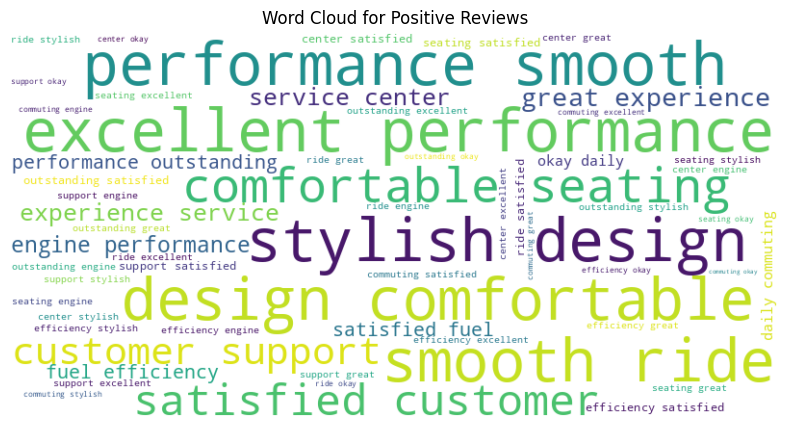

In [171]:
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_feedback)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.savefig('wordcloud_positive.png')
plt.show()

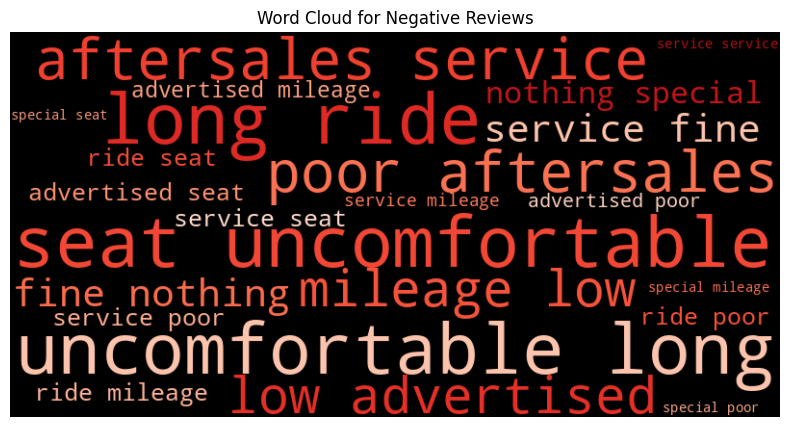

In [172]:
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_feedback)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.savefig('wordcloud_negative.png')
plt.show()

In [179]:
print("""
**Summary for ACI Motors’ Marketing Team**

3 Key Insights:

1. Sentiment Varies by Product Line
   Customer sentiment differs across Yamaha products—some are praised for performance, others face recurring issues. This signals the need for customized marketing per product line.

2. After-Sales Service is a Major Pain Point
   Many customers express frustration over poor service and unresponsive after-sales support, which damages brand reputation and loyalty.

3. Performance Gaps Fuel Complaints
   Frequent mentions of engine problems and mileage not meeting expectations suggest a disconnect between marketing promises and real-world product performance.

Recommended Action:

Launch a “Service Excellence” Campaign
Invest in dealer training, set service quality standards, and highlight improved support in your messaging to rebuild trust and improve satisfaction.
""")



**Summary for ACI Motors’ Marketing Team**

3 Key Insights:

1. Sentiment Varies by Product Line
   Customer sentiment differs across Yamaha products—some are praised for performance, others face recurring issues. This signals the need for customized marketing per product line.

2. After-Sales Service is a Major Pain Point
   Many customers express frustration over poor service and unresponsive after-sales support, which damages brand reputation and loyalty.

3. Performance Gaps Fuel Complaints
   Frequent mentions of engine problems and mileage not meeting expectations suggest a disconnect between marketing promises and real-world product performance.

Recommended Action:

Launch a “Service Excellence” Campaign
Invest in dealer training, set service quality standards, and highlight improved support in your messaging to rebuild trust and improve satisfaction.

